In [1]:
import os
import sys
import numpy as np
import shapely
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from suncalc import get_position, get_times
from datetime import datetime, timezone

In [2]:
sys.path.append("../../src")

In [3]:
import vis
import main

In [4]:
temp = pd.read_csv('../../data/raw_data/ta_vp_rh_60_min_2022_09_01_2024_08_31_gap_filled_new.csv')
temp['datetime']=pd.to_datetime(temp['datetime'])
temp['datetime_UTC'] = temp['datetime']
temp['value'] = temp['ta']
temp = temp[temp['type'] == 'measured']

### Define nighttime

In [5]:
times = {}
lon = 7.85222
lat = 47.9959

for i in temp['datetime_UTC'].unique():
    times[i] = get_times(i, lon, lat)

temp['sunrise'] = temp['datetime_UTC'].apply(lambda x: times[x]['sunrise'].replace(tzinfo=timezone.utc))
temp['sunset'] = temp['datetime_UTC'].apply(lambda x: times[x]['sunset'].replace(tzinfo=timezone.utc))

temp['is_night'] = (temp['datetime_UTC'] < temp['sunrise']) | (temp['datetime_UTC'] > temp['sunset'])

In [6]:
temp = temp[temp['is_night']]

## Heat island hours defined as hours with standard deviation greater than 2 and no precipitation on that day or day before
### No precipitation on that day or day before

In [8]:
prec23 = pd.read_csv('../../data/raw_data/FRCHEM_2023_Precipitation_Daily_UTC.csv')
prec22 = pd.read_csv('../../data/raw_data/FRCHEM_2022_Precipitation_Daily_UTC.csv')
prec24 = pd.read_csv('../../data/raw_data/FRCHEM_2024_Precipitation_Daily_UTC.csv')
# concat prec22 and prec23
prec = pd.concat([prec22, prec23, prec24])
prec['datetime_UTC'] = pd.to_datetime(prec['YYYYMMDDHHMM_From'], format='%Y%m%d%H%M', utc=True)
prec['Precipitation_Sum_mm_day_before'] = prec['Precipitation_Sum_mm'].shift(1)
no_prec = prec[(prec['datetime_UTC'].dt.date.isin(temp['datetime_UTC'].dt.date)) & (prec['Precipitation_Sum_mm'] == 0) & (prec['Precipitation_Sum_mm_day_before'] == 0)]['datetime_UTC'].dt.date
temp = temp[temp['datetime_UTC'].dt.date.isin(no_prec)]

In [9]:
no_prec = prec[(prec['datetime_UTC'].dt.date.isin(temp['datetime_UTC'].dt.date)) & (prec['Precipitation_Sum_mm'] == 0) & (prec['Precipitation_Sum_mm_day_before'] == 0)]['datetime_UTC'].dt.date
#heat_island_dates = heat_island_dates[heat_island_dates.dt.date.isin(no_prec)]

In [10]:
temp = temp[temp['datetime_UTC'].dt.date.isin(no_prec)]

### Define months and pivot

In [11]:
temp_w = temp[temp['datetime_UTC'].dt.month.isin([12,1,2])]
temp_sp = temp[temp['datetime_UTC'].dt.month.isin([3,4,5])]
temp_s = temp[temp['datetime_UTC'].dt.month.isin([6,7,8])]
temp_a = temp[temp['datetime_UTC'].dt.month.isin([9,10,11])]

temp_w['datetime_UTC'] = temp_w['datetime_UTC'].astype(str)
temp_sp['datetime_UTC'] = temp_sp['datetime_UTC'].astype(str)
temp_s['datetime_UTC'] = temp_s['datetime_UTC'].astype(str)
temp_a['datetime_UTC'] = temp_a['datetime_UTC'].astype(str)
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)

temp_w = temp_w.pivot(index='station_id', columns='datetime_UTC', values='value')
temp_sp = temp_sp.pivot(index='station_id', columns='datetime_UTC', values='value')
temp_s = temp_s.pivot(index='station_id', columns='datetime_UTC', values='value')
temp_a = temp_a.pivot(index='station_id', columns='datetime_UTC', values='value')
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_90634/4187433934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_w['datetime_UTC'] = temp_w['datetime_UTC'].astype(str)
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_90634/4187433934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_sp['datetime_UTC'] = temp_sp['datetime_UTC'].astype(str)
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_90634/4187433934.py:8: SettingWithCopyWarning: 
A value is trying to be set

### Standard deviation greater than 2

In [40]:
hin = temp.loc[:, temp.std() > 2].columns.values
hiwn = temp_w.loc[:, temp_w.std() > 2].columns.values
hisn = temp_s.loc[:, temp_s.std() > 2].columns.values
hian = temp_a.loc[:, temp_a.std() > 2].columns.values
hispn = temp_sp.loc[:, temp_sp.std() > 2].columns.values

In [13]:
pd.DataFrame(hin).to_csv('../../data/processed_data/2_year_heat_island_dates_night.csv', index=False)

In [14]:
hin = pd.read_csv('../../data/processed_data/2_year_heat_island_dates_night.csv')
hin = hin.values.flatten()

### Heat island statistics for all parameters

In [16]:
radius = 300
vars = gpd.read_parquet(f'../../data/processed_data/processed_station_params_{radius}.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF_3D','station_elevation_diff']
vars = vars.drop(to_remove, axis=1)

In [29]:
temp = pd.read_csv('../../data/raw_data/ta_vp_rh_60_min_2022_09_01_2024_08_31_gap_filled_new.csv')
temp['datetime']=pd.to_datetime(temp['datetime'])
temp['datetime_UTC'] = temp['datetime']
temp['value'] = temp['ta']
temp = temp[temp['type'] == 'measured']

temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [31]:
temp.index = temp.index.str[2:]

In [137]:
stats_dict = {}
param_list = []
spearman_r_list = []
spearman_p_list = []
pearson_list = []
r_squared_list = []
rmse_list = []
cooks_d_list = []
mutual_info_list = []

for var in vars.columns:
    print(var)
    data, mean, std, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, mi, y_pred = vis.stats_multiple_times(radius, var, hin, temp)
    param_list.append(var)
    spearman_r_list.append(spearman_corr)
    spearman_p_list.append(p_value)
    pearson_list.append(pearson_corr)
    r_squared_list.append(r_squared)
    rmse_list.append(rmse)
    cooks_d_list.append(cooks_d)
    mutual_info_list.append(mi)

stats_dict['parameter'] = param_list
stats_dict['spearman_r'] = spearman_r_list
stats_dict['spearman_p'] = spearman_p_list
stats_dict['pearson_r'] = pearson_list
stats_dict['r_squared'] = r_squared_list
stats_dict['rmse'] = rmse_list
stats_dict['cooks_d'] = cooks_d_list
stats_dict['mutual_info'] = mutual_info_list


stats_df = pd.DataFrame(stats_dict)

BuAdj
BuIBD
BuAre_mean
BuAre_median
BuAre_std
BuAre_min
BuAre_max
BuAre_sum
BuAre_mode
BuAre_IQR
BuAre_MAD
BuAre_skew
BuAre_per25
BuAre_per75
BuNum


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuHt_mean
BuHt_median
BuHt_std
BuHt_min
BuHt_max
BuHt_sum
BuHt_mode
BuHt_wmean
BuHt_wstd
BuHt_wmedian
BuHt_wmin
BuHt_wmax
BuHt_wsum
BuHt_wper25
BuHt_wper75
BuHt_IQR
BuHt_MAD
BuHt_skew
BuHt_per25
BuHt_per75
BuPer_mean
BuPer_median
BuPer_std
BuPer_min
BuPer_max
BuPer_sum
BuPer_mode
BuPer_wmean
BuPer_wstd
BuPer_wmedian
BuPer_wmin
BuPer_wmax
BuPer_wsum
BuPer_wper25
BuPer_wper75
BuPer_IQR
BuPer_MAD
BuPer_skew
BuPer_per25
BuPer_per75
BuLAL_mean
BuLAL_median
BuLAL_std
BuLAL_min
BuLAL_max
BuLAL_sum
BuLAL_mode
BuLAL_wmean
BuLAL_wstd
BuLAL_wmedian
BuLAL_wmin
BuLAL_wmax
BuLAL_wsum
BuLAL_wper25
BuLAL_wper75
BuLAL_IQR
BuLAL_MAD
BuLAL_skew
BuLAL_per25
BuLAL_per75
BuCCD_mean_mean
BuCCD_mean_median
BuCCD_mean_std
BuCCD_mean_min
BuCCD_mean_max
BuCCD_mean_sum
BuCCD_mean_mode
BuCCD_mean_wmean
BuCCD_mean_wstd
BuCCD_mean_wmedian
BuCCD_mean_wmin
BuCCD_mean_wmax
BuCCD_mean_wsum
BuCCD_mean_wper25
BuCCD_mean_wper75
BuCCD_mean_IQR
BuCCD_mean_MAD
BuCCD_mean_skew
BuCCD_mean_per25
BuCCD_mean_per75
BuCCD_std_mean
B

/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_std
CyAre_min


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_max
CyAre_sum
CyAre_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_wmean
CyAre_wstd
CyAre_wmedian


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_wmin


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_wmax
CyAre_wsum
CyAre_wper25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_wper75
CyAre_IQR


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_MAD


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_skew
CyAre_per25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyAre_per75


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_mean
CyInd_median


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_std
CyInd_min


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_max
CyInd_sum
CyInd_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_wmean
CyInd_wstd
CyInd_wmedian


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_wmin


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_wmax
CyInd_wsum
CyInd_wper25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_wper75
CyInd_IQR


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_MAD


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_skew
CyInd_per25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


CyInd_per75


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuCCo_mean
BuCCo_median
BuCCo_std
BuCCo_min
BuCCo_max
BuCCo_sum
BuCCo_mode
BuCCo_wmean
BuCCo_wstd
BuCCo_wmedian
BuCCo_wmin
BuCCo_wmax
BuCCo_wsum
BuCCo_wper25
BuCCo_wper75
BuCCo_IQR
BuCCo_MAD
BuCCo_skew
BuCCo_per25
BuCCo_per75
BuCWA_mean
BuCWA_median
BuCWA_std
BuCWA_min
BuCWA_max
BuCWA_sum
BuCWA_mode
BuCWA_wmean
BuCWA_wstd
BuCWA_wmedian
BuCWA_wmin
BuCWA_wmax
BuCWA_wsum
BuCWA_wper25
BuCWA_wper75
BuCWA_IQR
BuCWA_MAD
BuCWA_skew
BuCWA_per25
BuCWA_per75
BuCon_mean
BuCon_median
BuCon_std
BuCon_min
BuCon_max


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuCon_sum
BuCon_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuCon_wmean
BuCon_wstd
BuCon_wmedian
BuCon_wmin
BuCon_wmax
BuCon_wsum
BuCon_wper25
BuCon_wper75
BuCon_IQR
BuCon_MAD
BuCon_skew
BuCon_per25
BuCon_per75
BuElo_mean
BuElo_median
BuElo_std
BuElo_min
BuElo_max
BuElo_sum
BuElo_mode
BuElo_wmean
BuElo_wstd
BuElo_wmedian
BuElo_wmin
BuElo_wmax
BuElo_wsum
BuElo_wper25
BuElo_wper75
BuElo_IQR
BuElo_MAD
BuElo_skew
BuElo_per25
BuElo_per75
BuERI_mean
BuERI_median
BuERI_std
BuERI_min
BuERI_max
BuERI_sum
BuERI_mode
BuERI_wmean
BuERI_wstd
BuERI_wmedian
BuERI_wmin
BuERI_wmax
BuERI_wsum
BuERI_wper25
BuERI_wper75
BuERI_IQR
BuERI_MAD
BuERI_skew
BuERI_per25
BuERI_per75
BuFR_mean
BuFR_median
BuFR_std
BuFR_min
BuFR_max
BuFR_sum
BuFR_mode
BuFR_wmean
BuFR_wstd
BuFR_wmedian
BuFR_wmin
BuFR_wmax
BuFR_wsum
BuFR_wper25
BuFR_wper75
BuFR_IQR
BuFR_MAD
BuFR_skew
BuFR_per25
BuFR_per75
BuFF_mean
BuFF_median
BuFF_std
BuFF_min
BuFF_max
BuFF_sum
BuFF_mode
BuFF_wmean
BuFF_wstd
BuFF_wmedian
BuFF_wmin
BuFF_wmax
BuFF_wsum
BuFF_wper25
BuFF_wper75
BuFF_IQR
BuFF_MAD
BuFF_skew
BuFF_pe

/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuSWR_max
BuSWR_sum
BuSWR_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuSWR_wmean
BuSWR_wstd
BuSWR_wmedian
BuSWR_wmin
BuSWR_wmax
BuSWR_wsum
BuSWR_wper25
BuSWR_wper75
BuSWR_IQR
BuSWR_MAD
BuSWR_skew
BuSWR_per25
BuSWR_per75
BuOri_mean
BuOri_median
BuOri_std
BuOri_min
BuOri_max
BuOri_sum
BuOri_mode
BuOri_wmean
BuOri_wstd
BuOri_wmedian
BuOri_wmin
BuOri_wmax
BuOri_wsum
BuOri_wper25
BuOri_wper75
BuOri_IQR
BuOri_MAD
BuOri_skew
BuOri_per25
BuOri_per75
BuAli_mean
BuAli_median
BuAli_std
BuAli_min
BuAli_max
BuAli_sum
BuAli_mode
BuAli_wmean
BuAli_wstd
BuAli_wmedian
BuAli_wmin
BuAli_wmax
BuAli_wsum
BuAli_wper25
BuAli_wper75
BuAli_IQR
BuAli_MAD
BuAli_skew
BuAli_per25
BuAli_per75
StrAli_mean
StrAli_median
StrAli_std
StrAli_min
StrAli_max
StrAli_sum
StrAli_mode
StrAli_wmean
StrAli_wstd
StrAli_wmedian
StrAli_wmin
StrAli_wmax
StrAli_wsum
StrAli_wper25
StrAli_wper75
StrAli_IQR
StrAli_MAD
StrAli_skew
StrAli_per25
StrAli_per75
BuCir_mean
BuCir_median
BuCir_std
BuCir_min
BuCir_max
BuCir_sum
BuCir_mode
BuCir_wmean
BuCir_wstd
BuCir_wmedian
BuCir_wmin
BuCir_wmax
BuCir_wsum
BuCir_

/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_median
BumVE_3D_std


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_min


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_max


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_sum
BumVE_3D_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_wmean
BumVE_3D_wstd
BumVE_3D_wmedian


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_wmin
BumVE_3D_wmax


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_wsum
BumVE_3D_wper25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_wper75


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_IQR


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_MAD


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_skew
BumVE_3D_per25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BumVE_3D_per75
BuMVE_3D_mean


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_median
BuMVE_3D_std


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_min


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_max
BuMVE_3D_sum
BuMVE_3D_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_wmean
BuMVE_3D_wstd
BuMVE_3D_wmedian


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_wmin


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_wmax
BuMVE_3D_wsum


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_wper25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_wper75


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_IQR
BuMVE_3D_MAD


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_skew
BuMVE_3D_per25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuMVE_3D_per75


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuFF_3D_mean
BuFF_3D_median
BuFF_3D_std
BuFF_3D_min
BuFF_3D_max
BuFF_3D_sum
BuFF_3D_mode
BuFF_3D_wmean
BuFF_3D_wstd
BuFF_3D_wmedian
BuFF_3D_wmin
BuFF_3D_wmax
BuFF_3D_wsum
BuFF_3D_wper25
BuFF_3D_wper75
BuFF_3D_IQR
BuFF_3D_MAD
BuFF_3D_skew
BuFF_3D_per25
BuFF_3D_per75
BuEPI_3D_mean
BuEPI_3D_median
BuEPI_3D_std
BuEPI_3D_min
BuEPI_3D_max
BuEPI_3D_sum
BuEPI_3D_mode
BuEPI_3D_wmean
BuEPI_3D_wstd
BuEPI_3D_wmedian
BuEPI_3D_wmin
BuEPI_3D_wmax
BuEPI_3D_wsum
BuEPI_3D_wper25
BuEPI_3D_wper75
BuEPI_3D_IQR
BuEPI_3D_MAD
BuEPI_3D_skew
BuEPI_3D_per25
BuEPI_3D_per75
BuProx_mean
BuProx_median
BuProx_std
BuProx_min
BuProx_max
BuProx_sum
BuProx_mode
BuProx_wmean
BuProx_wstd
BuProx_wmedian
BuProx_wmin
BuProx_wmax
BuProx_wsum
BuProx_wper25
BuProx_wper75
BuProx_IQR
BuProx_MAD
BuProx_skew
BuProx_per25
BuProx_per75
BuProx_3D_mean
BuProx_3D_median
BuProx_3D_std
BuProx_3D_min
BuProx_3D_max
BuProx_3D_sum
BuProx_3D_mode
BuProx_3D_wmean
BuProx_3D_wstd
BuProx_3D_wmedian
BuProx_3D_wmin
BuProx_3D_wmax
BuProx_3D_wsum
BuPro

/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_median


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_std


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_min


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_max
BuEx_3D_sum


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_wmean
BuEx_3D_wstd
BuEx_3D_wmedian


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_wmin


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_wmax


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_wsum
BuEx_3D_wper25


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_wper75
BuEx_3D_IQR


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_MAD


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuEx_3D_skew
BuEx_3D_per25
BuEx_3D_per75


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuSpi_mean
BuSpi_median
BuSpi_std
BuSpi_min
BuSpi_max
BuSpi_sum
BuSpi_mode
BuSpi_wmean
BuSpi_wstd
BuSpi_wmedian
BuSpi_wmin
BuSpi_wmax
BuSpi_wsum
BuSpi_wper25
BuSpi_wper75
BuSpi_IQR
BuSpi_MAD
BuSpi_skew
BuSpi_per25
BuSpi_per75
BuSpi_3D_mean
BuSpi_3D_median
BuSpi_3D_std
BuSpi_3D_min
BuSpi_3D_max
BuSpi_3D_sum
BuSpi_3D_mode
BuSpi_3D_wmean
BuSpi_3D_wstd
BuSpi_3D_wmedian
BuSpi_3D_wmin
BuSpi_3D_wmax
BuSpi_3D_wsum
BuSpi_3D_wper25
BuSpi_3D_wper75
BuSpi_3D_IQR
BuSpi_3D_MAD
BuSpi_3D_skew
BuSpi_3D_per25
BuSpi_3D_per75
BuPerC_mean
BuPerC_median
BuPerC_std
BuPerC_min
BuPerC_max
BuPerC_sum
BuPerC_mode
BuPerC_wmean
BuPerC_wstd
BuPerC_wmedian
BuPerC_wmin
BuPerC_wmax
BuPerC_wsum
BuPerC_wper25
BuPerC_wper75
BuPerC_IQR
BuPerC_MAD
BuPerC_skew
BuPerC_per25
BuPerC_per75
BuCf_3D_mean
BuCf_3D_median
BuCf_3D_std
BuCf_3D_min
BuCf_3D_max
BuCf_3D_sum
BuCf_3D_mode
BuCf_3D_wmean
BuCf_3D_wstd
BuCf_3D_wmedian
BuCf_3D_wmin
BuCf_3D_wmax
BuCf_3D_wsum
BuCf_3D_wper25
BuCf_3D_wper75
BuCf_3D_IQR
BuCf_3D_MAD
BuCf_3D_skew
BuCf

/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuSWA_3D_max
BuSWA_3D_sum
BuSWA_3D_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuSWA_3D_wmean
BuSWA_3D_wstd
BuSWA_3D_wmedian
BuSWA_3D_wmin
BuSWA_3D_wmax
BuSWA_3D_wsum
BuSWA_3D_wper25
BuSWA_3D_wper75
BuSWA_3D_IQR
BuSWA_3D_MAD
BuSWA_3D_skew
BuSWA_3D_per25
BuSWA_3D_per75
BuSurf_3D_mean
BuSurf_3D_median
BuSurf_3D_std
BuSurf_3D_min
BuSurf_3D_max
BuSurf_3D_sum
BuSurf_3D_mode
BuSurf_3D_wmean
BuSurf_3D_wstd
BuSurf_3D_wmedian
BuSurf_3D_wmin
BuSurf_3D_wmax
BuSurf_3D_wsum
BuSurf_3D_wper25
BuSurf_3D_wper75
BuSurf_3D_IQR
BuSurf_3D_MAD
BuSurf_3D_skew
BuSurf_3D_per25
BuSurf_3D_per75
BuVol_3D_mean
BuVol_3D_median
BuVol_3D_std
BuVol_3D_min
BuVol_3D_max
BuVol_3D_sum
BuVol_3D_mode
BuVol_3D_wmean
BuVol_3D_wstd
BuVol_3D_wmedian
BuVol_3D_wmin
BuVol_3D_wmax
BuVol_3D_wsum
BuVol_3D_wper25
BuVol_3D_wper75
BuVol_3D_IQR
BuVol_3D_MAD
BuVol_3D_skew
BuVol_3D_per25
BuVol_3D_per75
BuSA_3D_mean
BuSA_3D_median
BuSA_3D_std
BuSA_3D_min
BuSA_3D_max
BuSA_3D_sum
BuSA_3D_mode
BuSA_3D_wmean
BuSA_3D_wstd
BuSA_3D_wmedian
BuSA_3D_wmin
BuSA_3D_wmax
BuSA_3D_wsum
BuSA_3D_wper25
BuSA_3D_wper75
BuSA_3D_IQR
BuSA_

/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuSWR_3D_max
BuSWR_3D_sum
BuSWR_3D_mode


/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])


BuSWR_3D_wmean
BuSWR_3D_wstd
BuSWR_3D_wmedian
BuSWR_3D_wmin
BuSWR_3D_wmax
BuSWR_3D_wsum
BuSWR_3D_wper25
BuSWR_3D_wper75
BuSWR_3D_IQR
BuSWR_3D_MAD
BuSWR_3D_skew
BuSWR_3D_per25
BuSWR_3D_per75
BuEWA_3D_mean
BuEWA_3D_median
BuEWA_3D_std
BuEWA_3D_min
BuEWA_3D_max
BuEWA_3D_sum
BuEWA_3D_mode
BuEWA_3D_wmean
BuEWA_3D_wstd
BuEWA_3D_wmedian
BuEWA_3D_wmin
BuEWA_3D_wmax
BuEWA_3D_wsum
BuEWA_3D_wper25
BuEWA_3D_wper75
BuEWA_3D_IQR
BuEWA_3D_MAD
BuEWA_3D_skew
BuEWA_3D_per25
BuEWA_3D_per75
BuEWR_3D_mean
BuEWR_3D_median
BuEWR_3D_std
BuEWR_3D_min
BuEWR_3D_max
BuEWR_3D_sum
BuEWR_3D_mode
BuEWR_3D_wmean
BuEWR_3D_wstd
BuEWR_3D_wmedian
BuEWR_3D_wmin
BuEWR_3D_wmax
BuEWR_3D_wsum
BuEWR_3D_wper25
BuEWR_3D_wper75
BuEWR_3D_IQR
BuEWR_3D_MAD
BuEWR_3D_skew
BuEWR_3D_per25
BuEWR_3D_per75
StrLen_mean
StrLen_median
StrLen_std
StrLen_min
StrLen_max
StrLen_sum
StrLen_mode
StrLen_IQR
StrLen_MAD
StrLen_skew
StrLen_per25
StrLen_per75
StrW_mean
StrW_median
StrW_std
StrW_min
StrW_max
StrW_sum
StrW_mode
StrW_IQR
StrW_MAD
StrW_skew


In [57]:
# all params

In [138]:
stats_df.to_csv(f'../../data/processed_data/heat_island_stats_{radius}_2024.csv')
stats_df.to_excel(f'../../data/processed_data/heat_island_stats_{radius}_2024.xlsx', index=True, header=True)

In [19]:
stats_df = pd.read_csv(f'../../data/processed_data/heat_island_stats_{radius}_2024.csv')

### Plots

In [20]:
radius = 300

In [22]:
var_name_mapping = {
    'BuAre_sum': '$\it{A_B}$',
    'BuVol_3D_sum': '$\it{V_B}$',
    'BuEWA_3D_sum': '$\it{A_F}$',
    'BuIBD': '$\it{IBD}$', 
    'BuAdj': '$\it{Adj}$',
    'BuSWR_3D_median': '$\it{SWR}$',
    'BuHt_wmean': '$\it{H_B^A}$',
    'StrHW_median': '$\it{H/W}$',
    'SVF_3D_mean': '$\it{SVF}$',
    'BuERI_mode': '$\it{ERI}$',
    'StrClo400_median': '$\it{C}$'}

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:10: SyntaxWarning: invalid escape sequence '\i'
<>:11: SyntaxWarning: invalid escape sequence '\i'
<>:12: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:10: SyntaxWarning: invalid escape sequence '

In [25]:
stations = pd.read_csv("../../data/raw_data/Freiburg-Street-Level-Weather-Station-Network-MetaData-V1-0.csv")

In [36]:
vars.index = vars.index.str[2:]

Spearman ρ: 0.47
Mutual Info.: 0.46
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: 0.49
Mutual Info.: 0.46
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: 0.48
Mutual Info.: 0.46
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: -0.42
Mutual Info.: 0.42
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: 0.55
Mutual Info.: 0.44
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: 0.48
Mutual Info.: 0.49
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: 0.51
Mutual Info.: 0.46
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: 0.55
Mutual Info.: 0.48
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: -0.45
Mutual Info.: 0.47
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: -0.39
Mutual Info.: 0.43
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


Spearman ρ: 0.34
Mutual Info.: 0.47
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


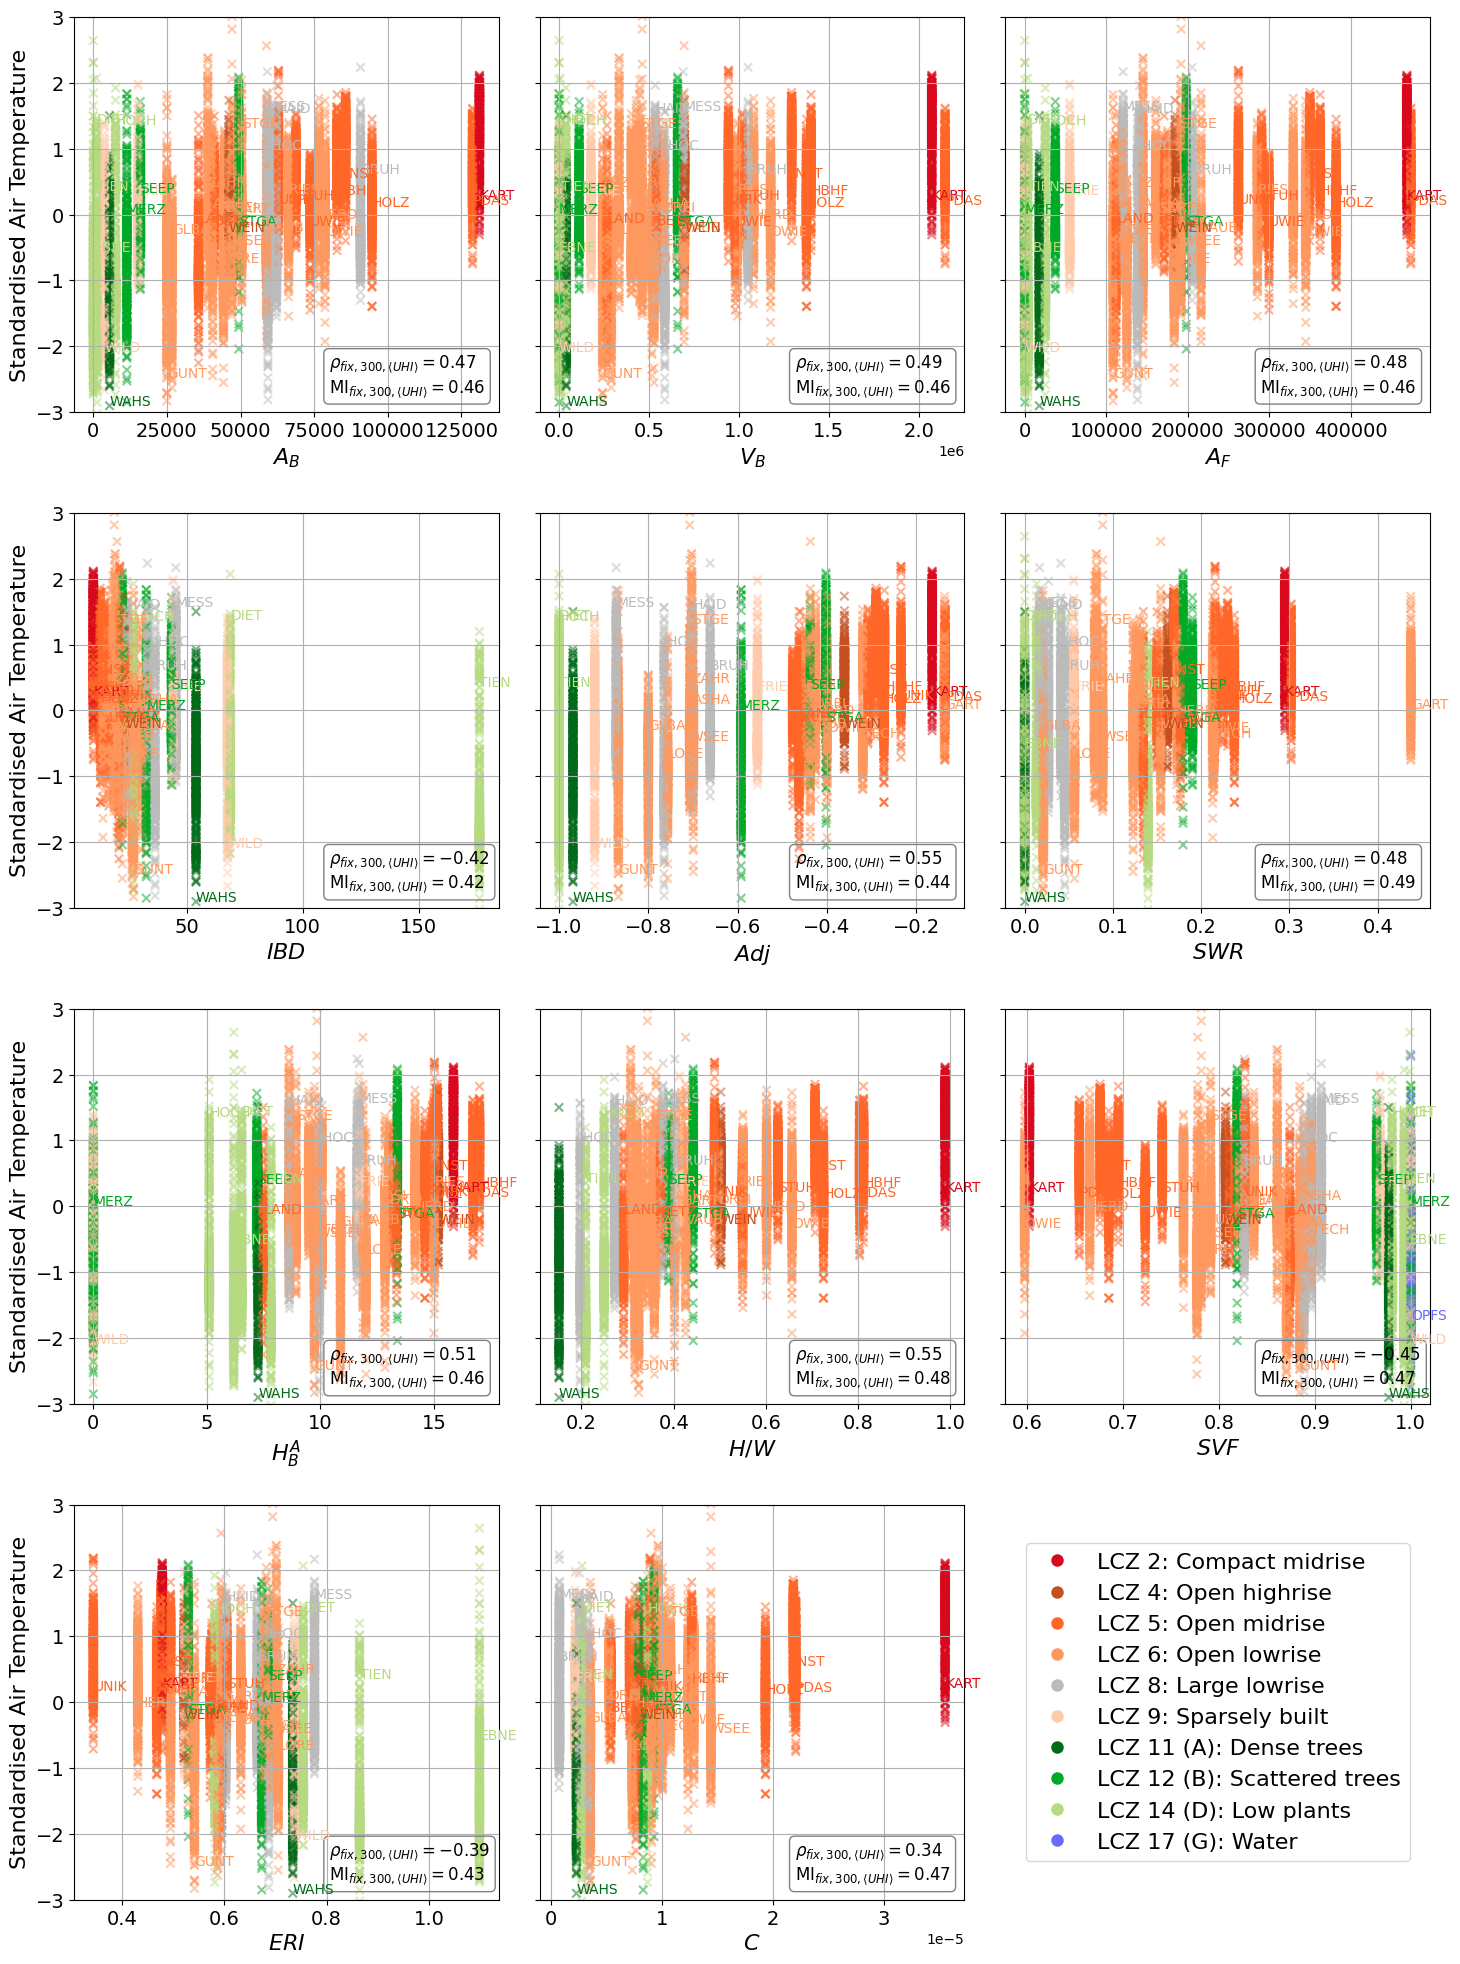

In [42]:
# mean/std normalisation

# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))

for i, ax in enumerate(axs.flat):
    if i in range(0,11):
        vis.simple_plot_reduced(ax, 300, vars, params[i], hin, temp, stations, var_name_mapping)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel("Standardised Air Temperature", fontsize=16)
        ax.set_ylim(-3,3)   
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks

    else:
        legend_elements = vis.custom_lcz_legend()
        ax.legend(handles=legend_elements, loc='center', fontsize=16)
        ax.set_axis_off()
  
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('../../figures/fig5/hin_vs_params_300m_2024.png')
plt.savefig('../../figures/fig5/hin_vs_params_300m_2024.pdf')
plt.savefig('../../figures/fig5/hin_vs_params_300m_2024.svg')
plt.show()

# Winter

Spearman ρ: 0.39
Mutual Info.: 0.42
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}
Spearman ρ: 0.41
Mutual Info.: 0.39
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A

/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarni

Spearman ρ: -0.39
Mutual Info.: 0.39
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}
Spearman ρ: 0.50
Mutual Info.: 0.43
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006

/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarni

Spearman ρ: 0.44
Mutual Info.: 0.44
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}
Spearman ρ: 0.50
Mutual Info.: 0.47
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A

/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarni

Spearman ρ: -0.33
Mutual Info.: 0.40
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}
Spearman ρ: 0.36
Mutual Info.: 0.41
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006

/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


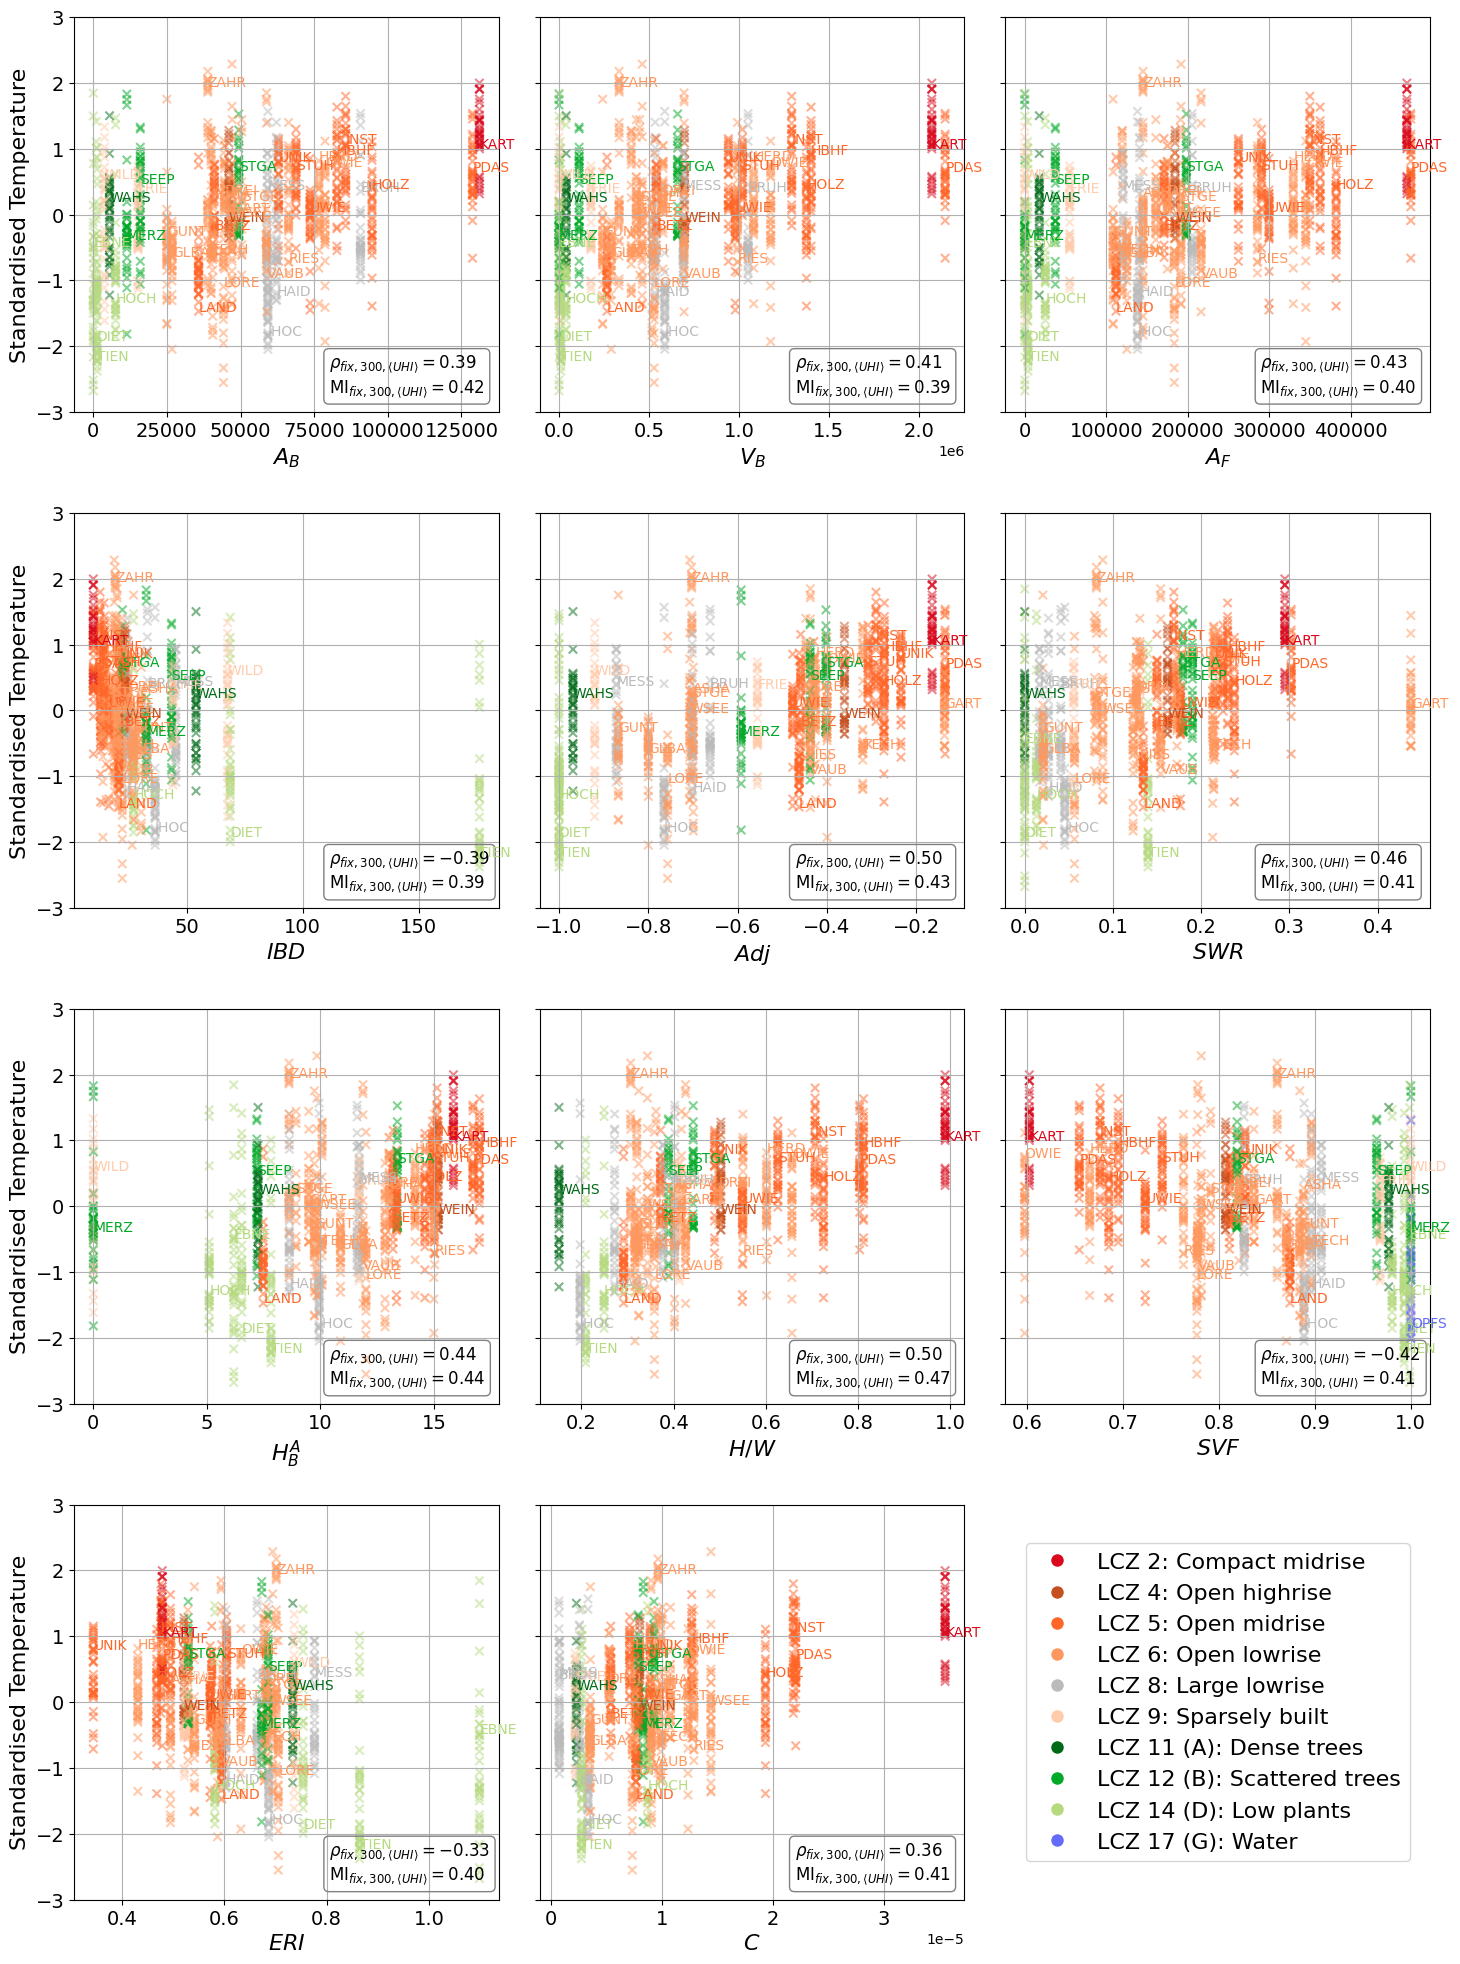

In [41]:
# mean/std normalisation

# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
#fig.suptitle('Nighttime Heat Island Temperatures against Parameters at 300m Radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    if i in range(0,11):
        vis.simple_plot_reduced(ax, 300, vars, params[i], hiwn, temp, stations, var_name_mapping)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel("Standardised Temperature", fontsize=16)
        ax.set_ylim(-3,3)   
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
    else:
        legend_elements = vis.custom_lcz_legend()
        ax.legend(handles=legend_elements, loc='center', fontsize=16)
        ax.set_axis_off()
  
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('../../figures/fig5/hiwn_vs_params_300m_2024.png')
plt.savefig('../../figures/fig5/hiwn_vs_params_300m_2024.pdf')
plt.show()

# Summer

Spearman ρ: 0.64
Mutual Info.: 0.87
Spearman ρ: 0.66
Mutual Info.: 0.91
Spearman ρ: 0.61
Mutual Info.: 0.86
Spearman ρ: -0.42
Mutual Info.: 0.74
Spearman ρ: 0.64
Mutual Info.: 0.79
Spearman ρ: 0.51
Mutual Info.: 0.84
Spearman ρ: 0.66
Mutual Info.: 0.86
Spearman ρ: 0.63
Mutual Info.: 0.88
Spearman ρ: -0.57
Mutual Info.: 0.93
Spearman ρ: -0.54
Mutual Info.: 0.85
Spearman ρ: 0.28
Mutual Info.: 0.72


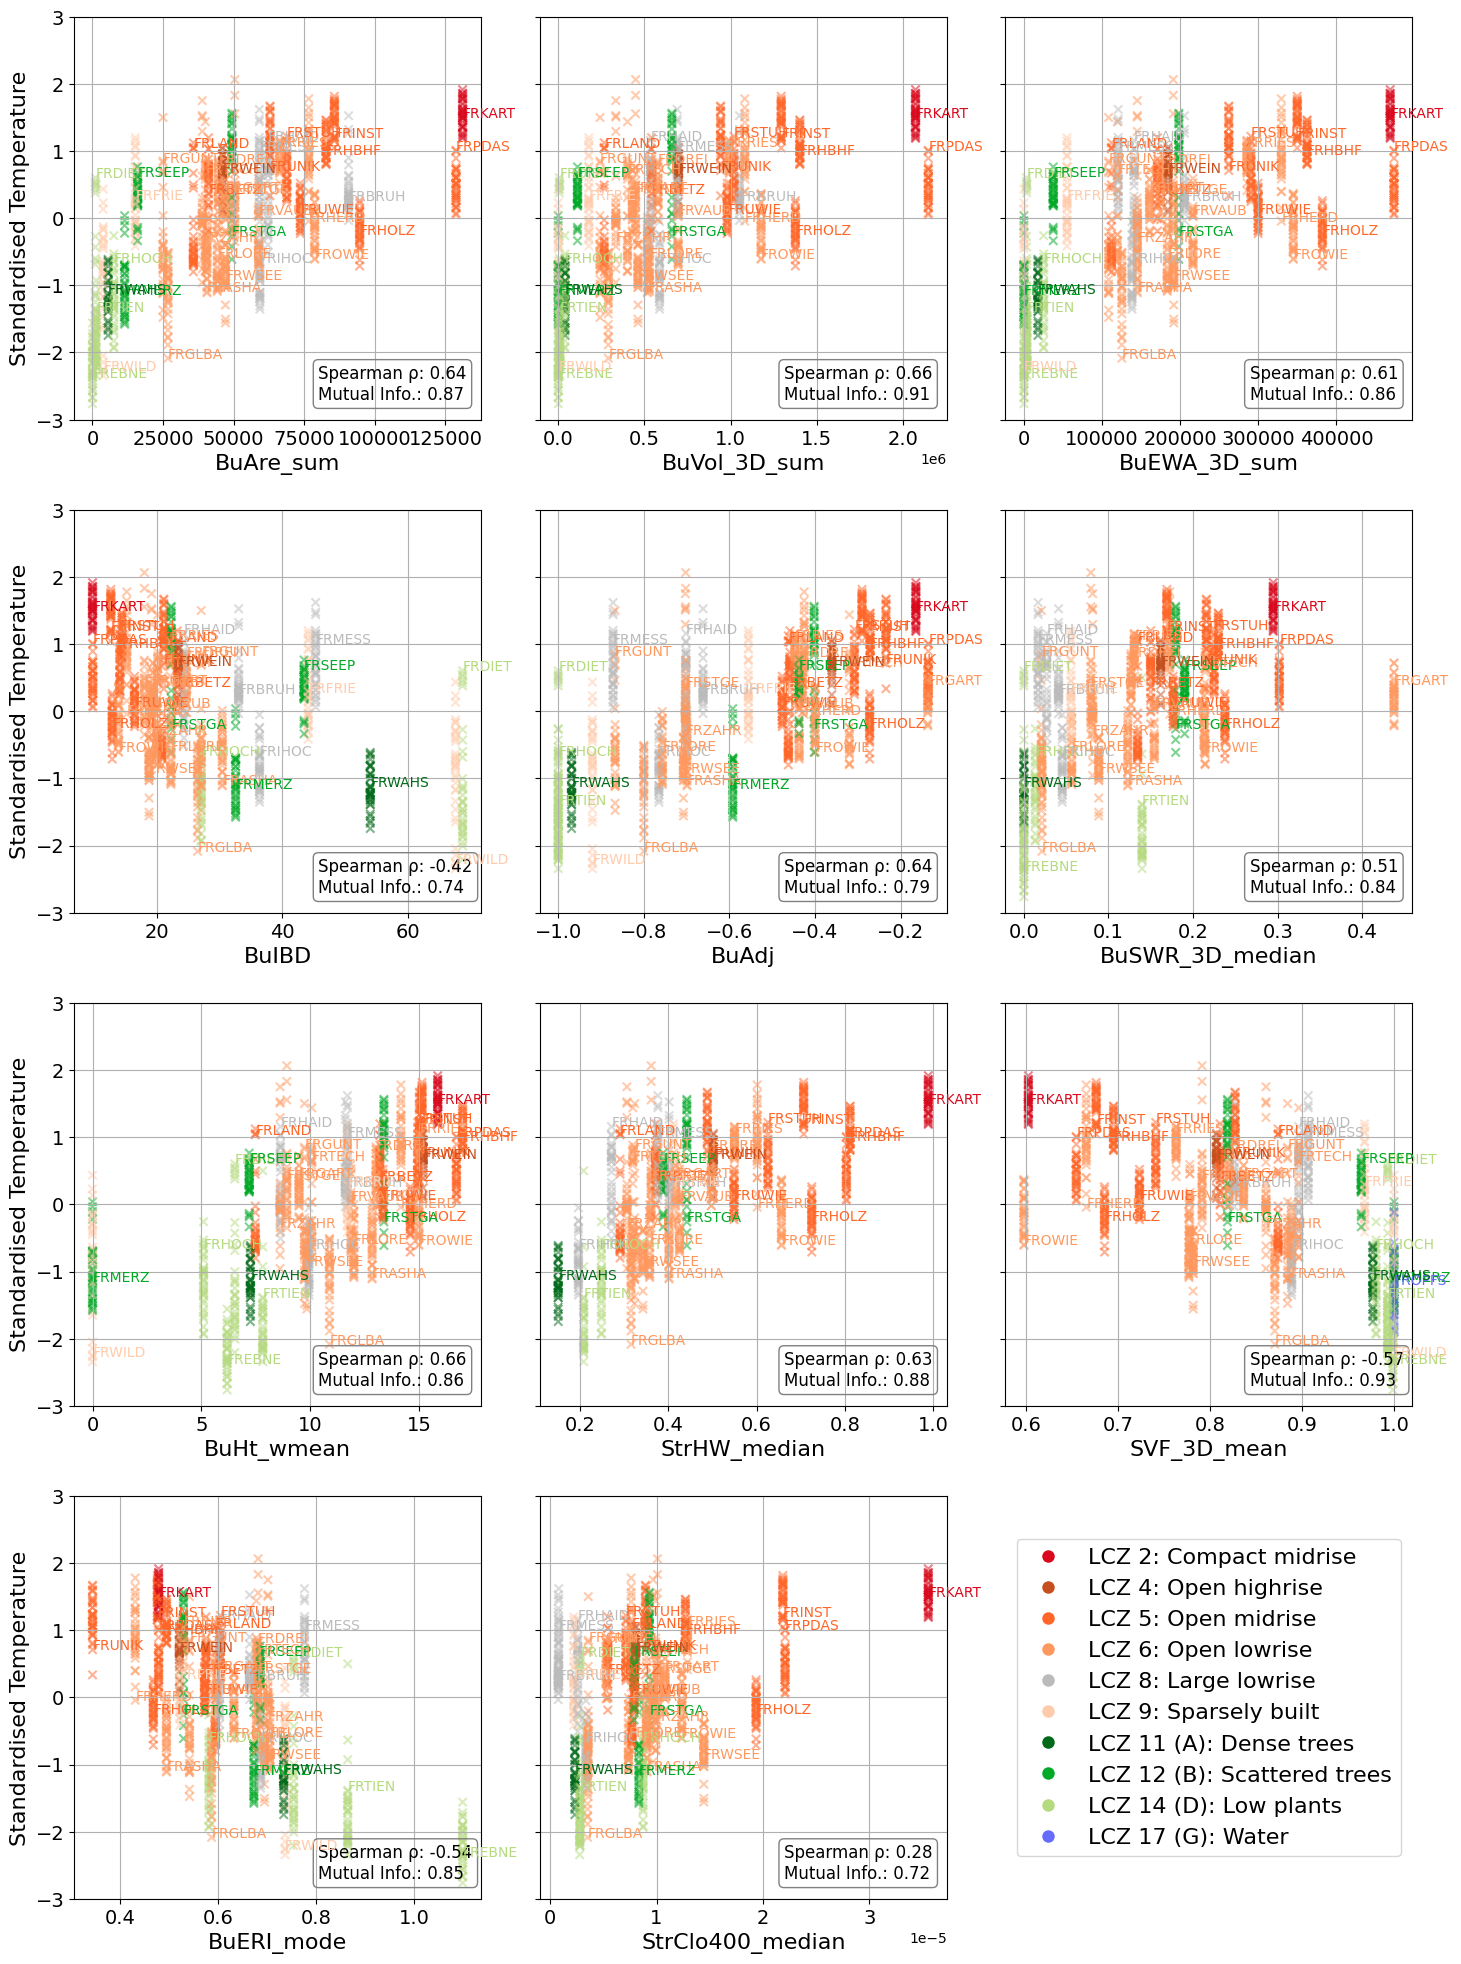

In [23]:
# mean/std normalisation

# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
#fig.suptitle('Nighttime Heat Island Temperatures against Parameters at 300m Radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    if i in range(0,11):
        vis.simple_plot_reduced(ax, 300, vars, params[i], hisn, temp, stations, var_name_mapping)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel("Standardised Temperature", fontsize=16)
        ax.set_ylim(-3,3)   
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
    else:
        legend_elements = vis.custom_lcz_legend()
        ax.legend(handles=legend_elements, loc='center', fontsize=16)
        ax.set_axis_off()
  
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('../../figures/fig5/hisn_vs_params_300m_2024.png')
plt.savefig('../../figures/fig5/hisn_vs_params_300m_2024.pdf')
plt.show()

# Spring

Spearman ρ: 0.55
Mutual Info.: 0.63
Spearman ρ: 0.58
Mutual Info.: 0.66
Spearman ρ: 0.57
Mutual Info.: 0.66
Spearman ρ: -0.43
Mutual Info.: 0.50
Spearman ρ: 0.64
Mutual Info.: 0.56
Spearman ρ: 0.57
Mutual Info.: 0.68
Spearman ρ: 0.61
Mutual Info.: 0.69
Spearman ρ: 0.65
Mutual Info.: 0.75
Spearman ρ: -0.52
Mutual Info.: 0.69
Spearman ρ: -0.50
Mutual Info.: 0.59
Spearman ρ: 0.36
Mutual Info.: 0.56


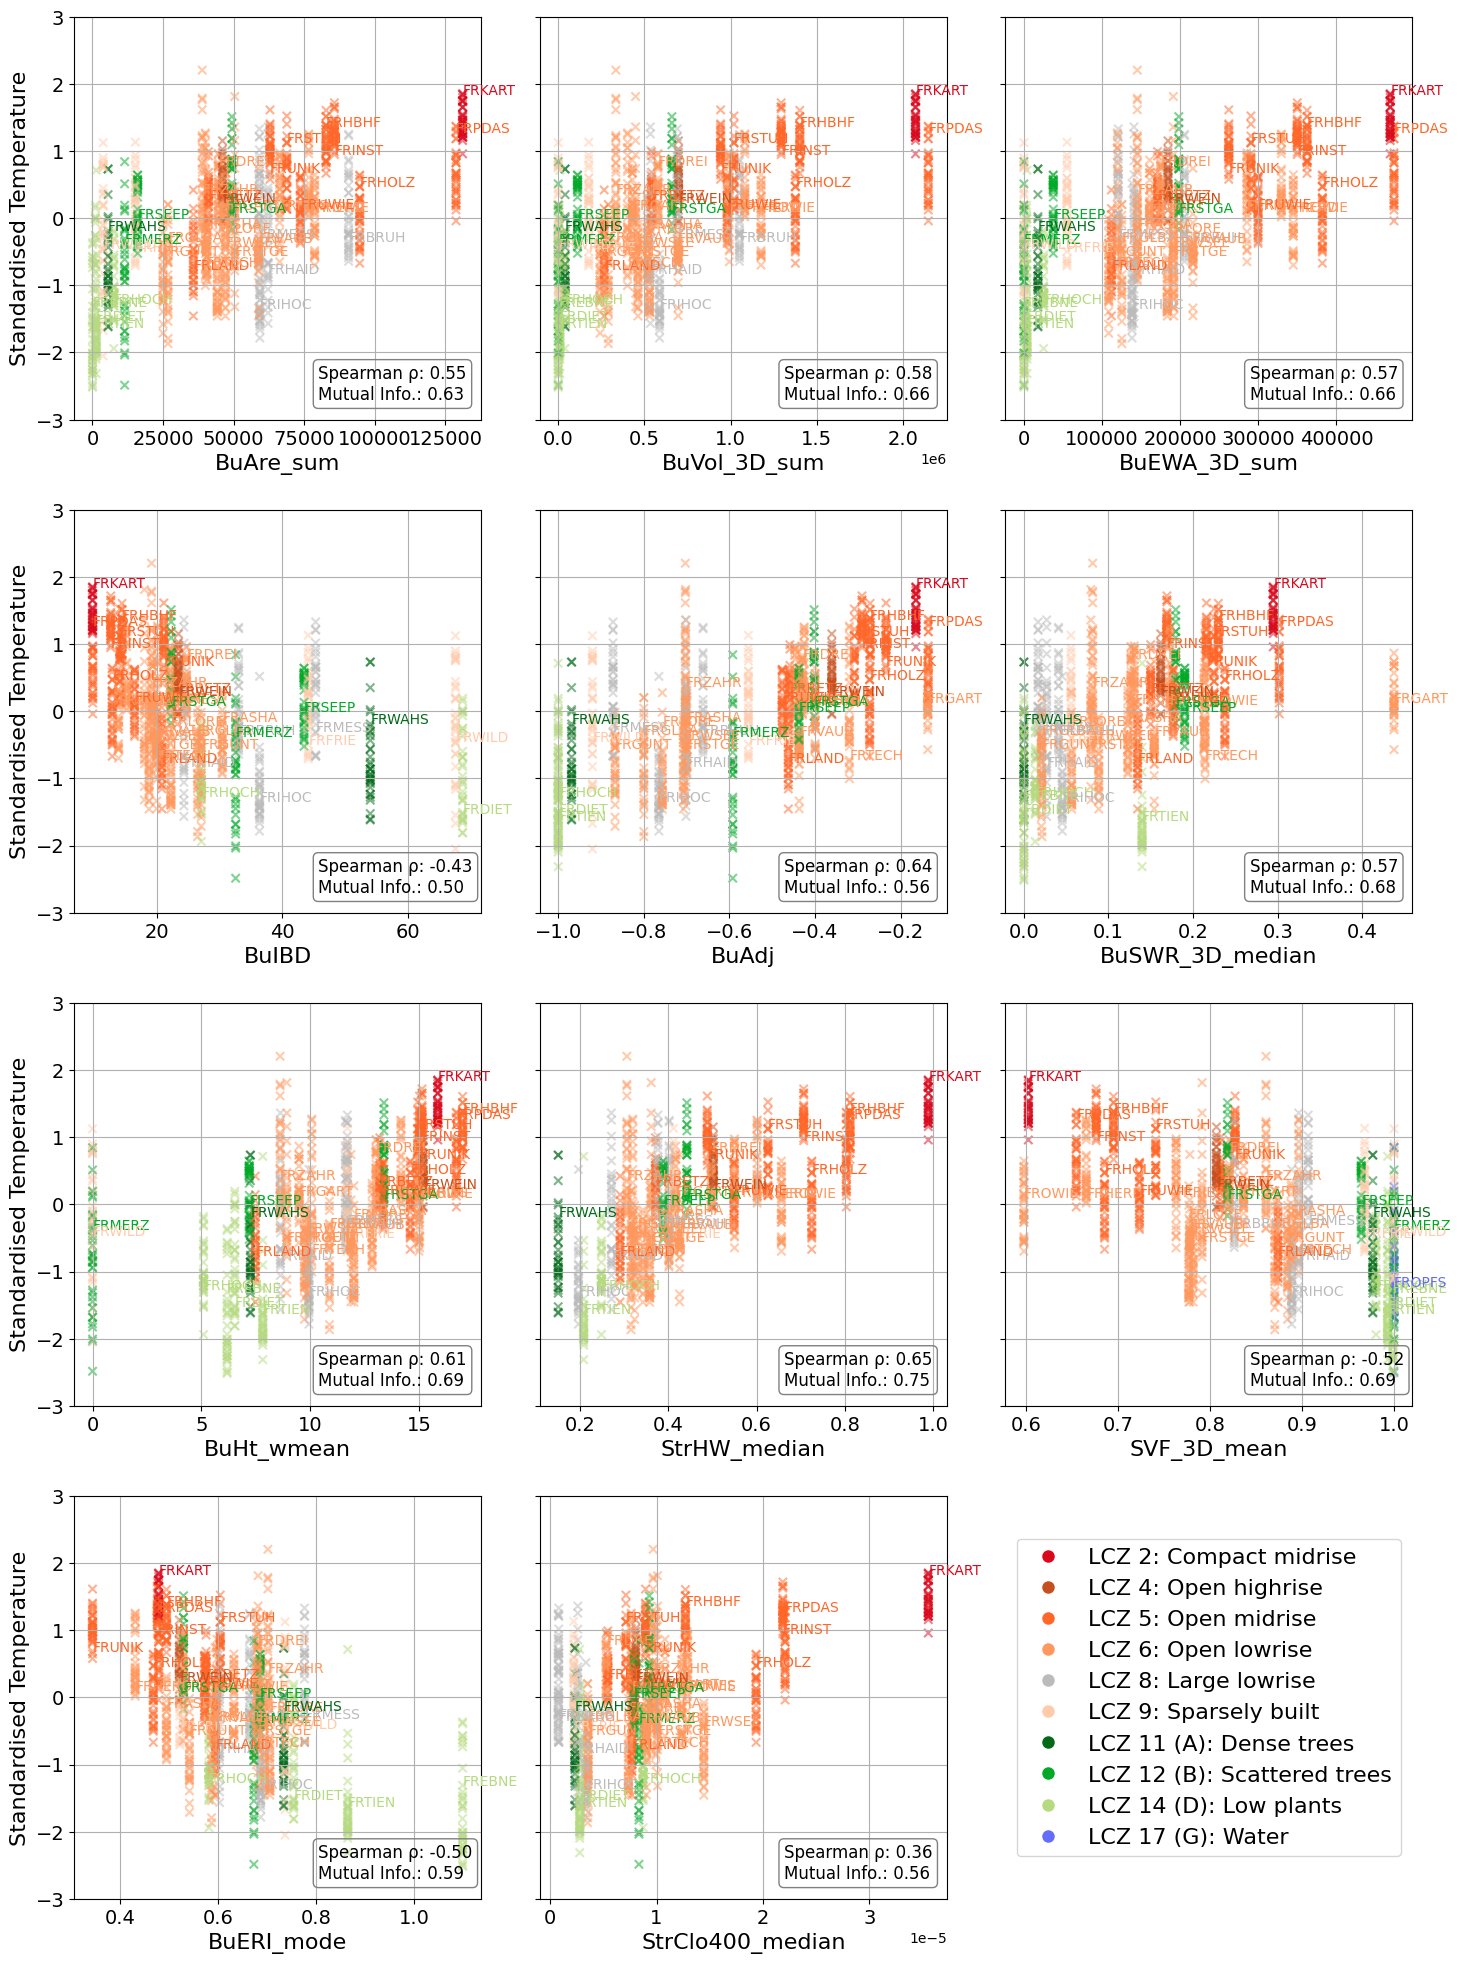

In [24]:
# mean/std normalisation

# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
#fig.suptitle('Nighttime Heat Island Temperatures against Parameters at 300m Radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    if i in range(0,11):
        vis.simple_plot_reduced(ax, 300, vars, params[i], hispn, temp, stations, var_name_mapping)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel("Standardised Temperature", fontsize=16)
        ax.set_ylim(-3,3)   
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
    else:
        legend_elements = vis.custom_lcz_legend()
        ax.legend(handles=legend_elements, loc='center', fontsize=16)
        ax.set_axis_off()
  
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('../../figures/fig5/hispn_vs_params_300m_2024.png')
plt.savefig('../../figures/fig5/hispn_vs_params_300m_2024.pdf')
plt.show()

# Autumns

Spearman ρ: 0.57
Mutual Info.: 0.80
Spearman ρ: 0.62
Mutual Info.: 0.81
Spearman ρ: 0.62
Mutual Info.: 0.81
Spearman ρ: -0.50
Mutual Info.: 0.71
Spearman ρ: 0.68
Mutual Info.: 0.77
Spearman ρ: 0.60
Mutual Info.: 0.87
Spearman ρ: 0.66
Mutual Info.: 0.82
Spearman ρ: 0.72
Mutual Info.: 0.90
Spearman ρ: -0.60
Mutual Info.: 0.80
Spearman ρ: -0.52
Mutual Info.: 0.74
Spearman ρ: 0.44
Mutual Info.: 0.82


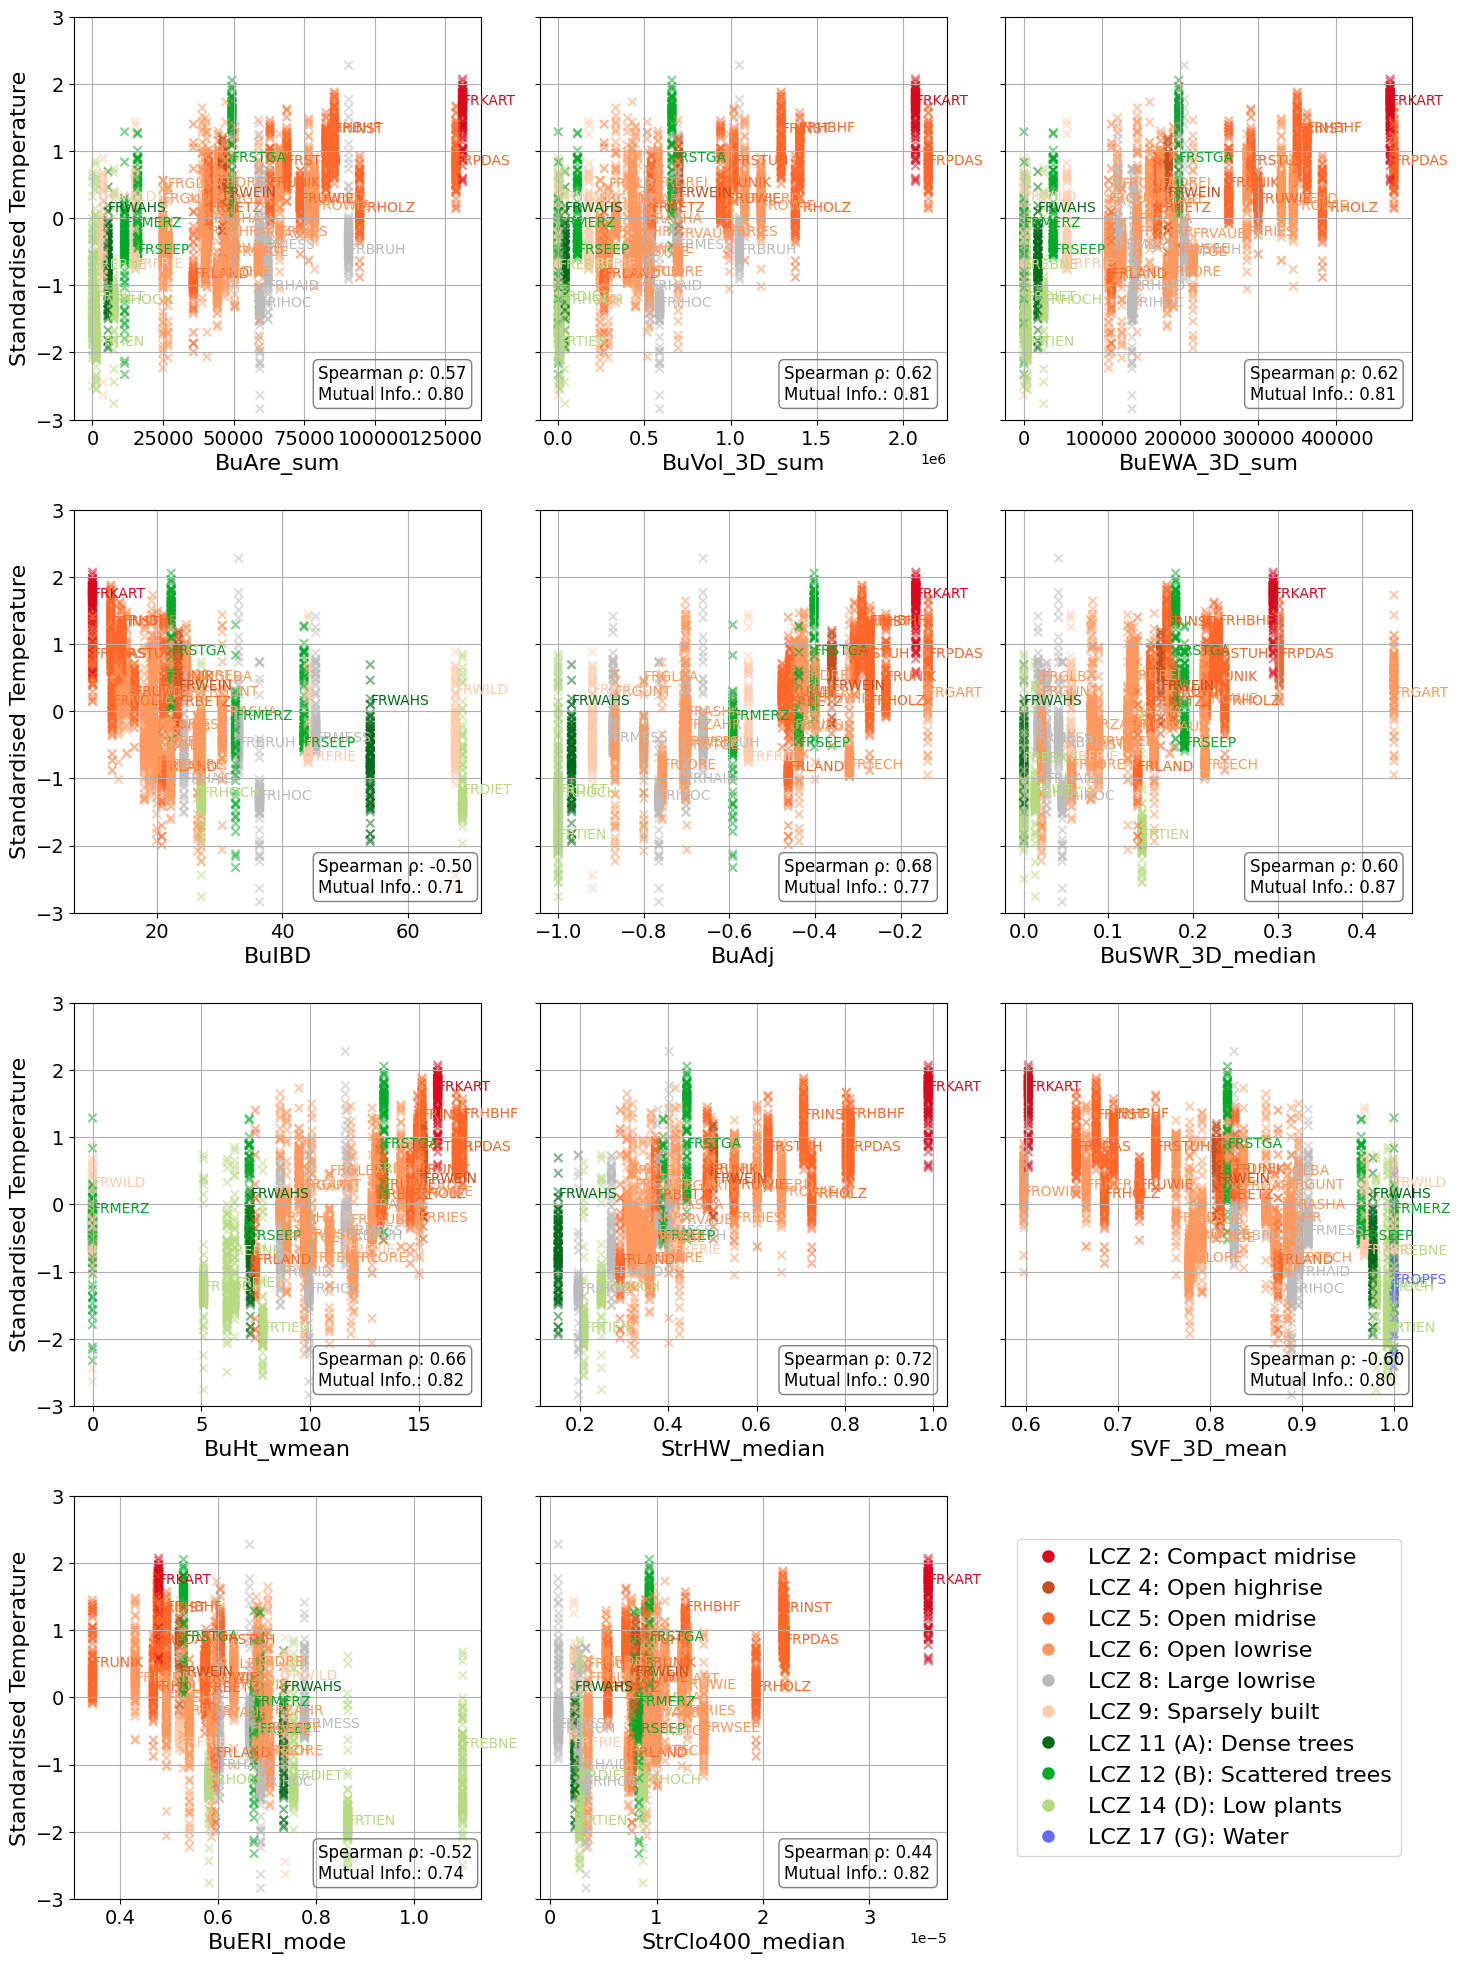

In [25]:
# mean/std normalisation

# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
#fig.suptitle('Nighttime Heat Island Temperatures against Parameters at 300m Radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    if i in range(0,11):
        vis.simple_plot_reduced(ax, 300, vars, params[i], hian, temp, stations, var_name_mapping)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel("Standardised Temperature", fontsize=16)
        ax.set_ylim(-3,3)   
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
    else:
        legend_elements = vis.custom_lcz_legend()
        ax.legend(handles=legend_elements, loc='center', fontsize=16)
        ax.set_axis_off()
  
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('../../figures/fig5/hian_vs_params_300m_2024.png')
plt.savefig('../../figures/fig5/hian_vs_params_300m_2024.pdf')
plt.show()

# All year

Spearman ρ: 0.44
Mutual Info.: 0.31
Spearman ρ: 0.43
Mutual Info.: 0.31
Spearman ρ: 0.40
Mutual Info.: 0.30
Spearman ρ: -0.28
Mutual Info.: 0.30
Spearman ρ: 0.38
Mutual Info.: 0.29
Spearman ρ: 0.32
Mutual Info.: 0.28
Spearman ρ: 0.39
Mutual Info.: 0.31
Spearman ρ: 0.34
Mutual Info.: 0.28
Spearman ρ: -0.33
Mutual Info.: 0.30
Spearman ρ: -0.26
Mutual Info.: 0.30
Spearman ρ: 0.17
Mutual Info.: 0.29


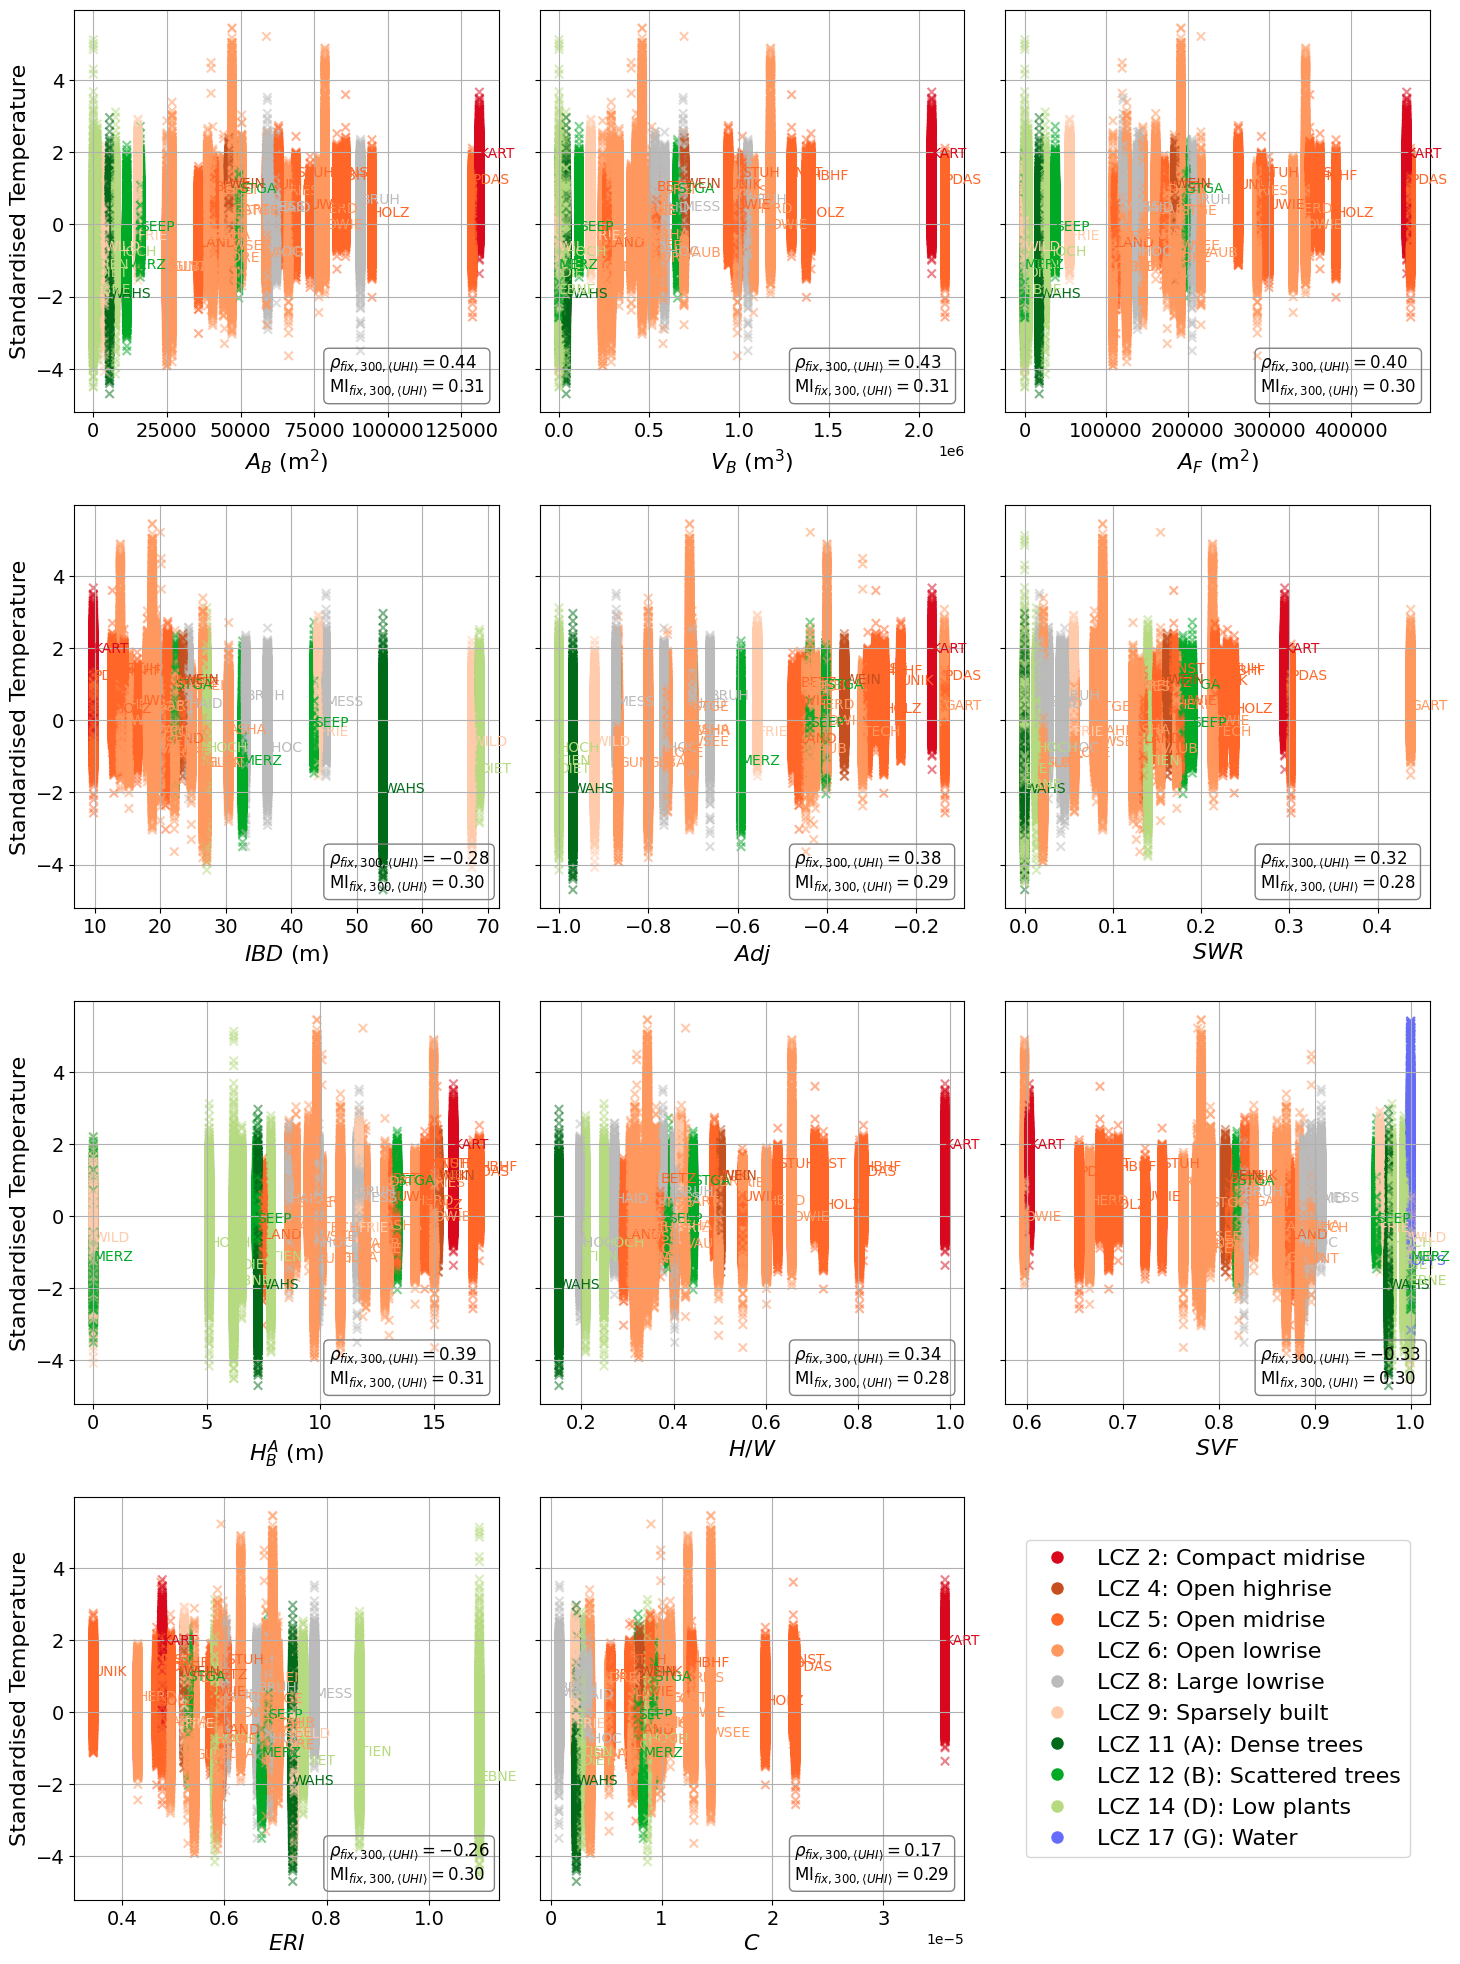

In [10]:
# mean/std normalisation

# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
#fig.suptitle('Nighttime Heat Island Temperatures against Parameters at 300m Radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    if i in range(0,11):
        vis.simple_plot_reduced(ax, 300, vars, params[i], temp.columns.values, temp, stations, var_name_mapping)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel("Standardised Temperature", fontsize=16)
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
    else:
        legend_elements = vis.custom_lcz_legend()
        ax.legend(handles=legend_elements, loc='center', fontsize=16)
        ax.set_axis_off()
  
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('../../figures/fig5/all_vs_params_300m_2024.png')
plt.savefig('../../figures/fig5/all_vs_params_300m_2024.pdf')
plt.show()

In [ ]:
# mean/std normalisation

# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
#fig.suptitle('Nighttime Heat Island Temperatures against Parameters at 300m Radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    if i in range(0,11):
        vis.simple_plot_reduced(ax, 300, vars, params[i], hiwn, temp, stations, var_name_mapping)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel("Standardised Temperature", fontsize=16)
        ax.set_ylim(-3,3)   
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
    else:
        legend_elements = vis.custom_lcz_legend()
        ax.legend(handles=legend_elements, loc='center', fontsize=16)
        ax.set_axis_off()
  
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('../../fig5/hiwn_vs_params_300m_2024.png')
plt.savefig('../../fig5/hiwn_vs_params_300m_2024.pdf')
plt.show()

### for spider plot values

In [44]:
vars_2 = ['BuAre_median','BuVol_3D_median','BuEWA_3D_median','BuSWR_median','BuHt_wmean','BuHt_max','StrHW_mean','SVF_3D_mean','BuERI_mode']

In [47]:
var_name_mapping_2 = {'BuAre_median': 'BuAre_median',
    'BuVol_3D_median': 'BuVol_3D_median',
    'BuEWA_3D_median': 'BuEWA_3D_median',
    'BuSWR_median': 'BuSWR_median',
    'BuHt_wmean': 'BuHt_wmean',
    'BuHt_max': 'BuHt_max',
    'StrHW_mean': 'StrHW_mean',
    'SVF_3D_mean': 'SVF_3D_mean',
    'BuERI_mode': 'BuERI_mode'}

In [ ]:
ax, radius, vars, var, time, stations

In [48]:
for i in vars_2:
    print(i)
    vis.simple_plot_reduced(ax, 300, vars, i, hin, temp, stations, var_name_mapping_2)

BuAre_median
Spearman ρ: 0.24
Mutual Info.: 0.44
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


BuVol_3D_median
Spearman ρ: 0.26
Mutual Info.: 0.45
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


BuEWA_3D_median
Spearman ρ: 0.16
Mutual Info.: 0.48
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


BuSWR_median
Spearman ρ: 0.50
Mutual Info.: 0.34
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


BuHt_wmean
Spearman ρ: 0.51
Mutual Info.: 0.46
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


BuHt_max
Spearman ρ: 0.43
Mutual Info.: 0.47
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


StrHW_mean
Spearman ρ: 0.55
Mutual Info.: 0.45
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


SVF_3D_mean
Spearman ρ: -0.45
Mutual Info.: 0.47
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')


BuERI_mode
Spearman ρ: -0.39
Mutual Info.: 0.43
{'ASHA': '#FF985E', 'BETZ': '#FF6628', 'BRUH': '#BBBBBB', 'DIET': '#B5DA7F', 'DREI': '#FF985E', 'EBNE': '#B5DA7F', 'EICH': '#006A18', 'FRIE': '#FFCBAB', 'GART': '#FF985E', 'GLBA': '#FF985E', 'GUNT': '#FF985E', 'HAID': '#BBBBBB', 'HBHF': '#FF6628', 'HERD': '#FF985E', 'HOCH': '#B5DA7F', 'HOLZ': '#FF6628', 'IHOC': '#BBBBBB', 'INST': '#FF6628', 'KART': '#D9081C', 'LAND': '#FF6628', 'LORE': '#FF985E', 'MERZ': '#00A926', 'MESS': '#BBBBBB', 'OPFS': '#656BFA', 'OWIE': '#FF985E', 'PDAS': '#FF6628', 'RIES': '#FF985E', 'SEEP': '#00A926', 'STGA': '#00A926', 'STGE': '#FF985E', 'STUH': '#FF6628', 'TECH': '#FF985E', 'TIEN': '#B5DA7F', 'UNIK': '#FF6628', 'UWIE': '#FF6628', 'VAUB': '#FF985E', 'WAHS': '#006A18', 'WEIN': '#C54F1E', 'WILD': '#FFCBAB', 'WITT': '#FFCBAB', 'WSEE': '#FF985E', 'ZAHR': '#FF985E'}


/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
